# Navigation

---

In this notebook, we will use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. algorithm - Deep Q-Learning

By using a neural network as a non linear function approximator, the reinforcement learning algorithm estimate the action-value function to converge to the optimal policy. In order to make the algorithm converge, two additional techniques are used - experience replay and fixed Q-targets.

At each time step:
- the agent select an action following an epsilo-greedy policy 
- then the agent receive reward and the next state from the environment
- the experience (including state, action, reward, next state) is stored in a memory pool
- sample a batch of experience from the pool and pass them through the local network and get the outputs 
- set the target Q value using a seperate target network
- perform a grediant descent step on the loss and update local network parameters
- soft update the target Q network parameters



### 4. Start the training in the Environment

In the next code cell, We will use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, a window should pop up that allows us to observe the agent, as it moves through the environment.

With the proper implementation of the training model, the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from navi_agent import Agent
seed = 0
agent = Agent(brain.vector_observation_space_size,brain.vector_action_space_size,seed)

The neural network architecture:
- 1st hidden layer: fully-connected linear layer with 512 rectifier units,
- 2nd hidden layer: fully-connected linear layer with 256 rectifier units,
- output layer: fully-connected linear layer with 4 output nodes (for 4 valid actions) without nonlinearity.  

Hyperparameters:

- replay buffer size = 1e5
- minibatch size = 64
- discount factor = 0.99
- TAU = 1e-3 for soft update of target parameters
- learning rate = 5e-4 
- UPDATE_EVERY = 4    


Episode :499	Score :17.0	Average Score :13.88

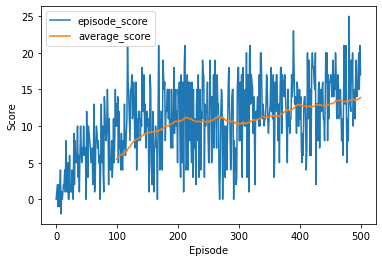

In [10]:
import torch
EPS = 0.005
num_episodes = 500
scores = []
scores_window = deque(maxlen=100)
average_scores = []
for i in range(num_episodes):
    brain_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = brain_info.vector_observations[0]            # get the current state
    score = 0                                            # initialize the score
    while True:
        action = agent.act(state, max(EPS,1.0/(i+1)))      # select an action
        brain_info = env.step(float(action))[brain_name] # send the action to the environment
        next_state = brain_info.vector_observations[0]   # get the next state
        reward = brain_info.rewards[0]                   # get the reward
        done = brain_info.local_done[0]                  # see if episode has finished
        score += reward                                  # update the score
        agent.step(state, action, reward, next_state, done)
        if done:                                         # exit loop if episode finished
            break
        state = next_state                               # roll over the state to next time step
    scores.append(score)
    scores_window.append(score)
    if len(scores_window)==100:
        average_scores.append(np.mean(scores_window))
    else:
        average_scores.append(None)
    print("\rEpisode :{}\tScore :{}\tAverage Score :{}".format(i, scores[i], average_scores[i]), end="")

torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

fig = plt.figure()
plt.plot(np.arange(num_episodes), scores, label="episode_score")
plt.plot(np.arange(num_episodes), average_scores, label="average_score")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()


In [11]:
env.close()

## Future ideas for improving the agent's performance

From the results above, we can see that pure Deep Q-learning with experience replay and fixed Q-targets works very well in training the agent in the banana collection environment. To improve the agent's performance and training efficiency even more, there are many extensions available, such as Double DQN, prioritized experience replay, Dualing DQN, etc. In the future, we can implement these extensions to the DQN.
Moreover, we can also try to use these algorithm by taking screen pixels as input.